###Loading the data

In [105]:
# Importing the libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm

In [106]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [107]:
# Downloading the torch dataset using torchvision.datasets
train_dataset = torchvision.datasets.CIFAR10(root='./cifar10', transform = torchvision.transforms.ToTensor(), download = True)
test_dataset = torchvision.datasets.CIFAR10(root='./cifar10', train=False,transform = torchvision.transforms.ToTensor(), download = True)

Files already downloaded and verified
Files already downloaded and verified


In [108]:
# Extract features (X_train) and labels (y_train)
X_train = torch.stack([img for img, _ in train_dataset], dim=0)
y_train = torch.tensor([label for _, label in train_dataset])

# Extract features (X_test) and labels (y_test)
X_test = torch.stack([img for img, _ in test_dataset], dim=0)
y_test = torch.tensor([label for _, label in test_dataset])

In [109]:
# Loading the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

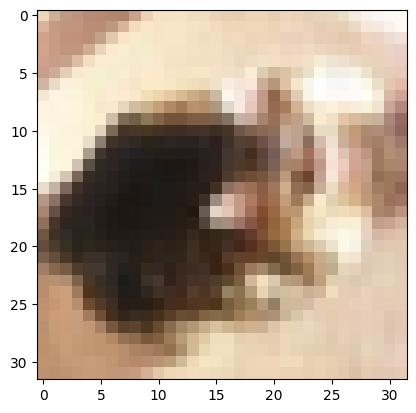

In [110]:
# Visualizing a sample
train_iter = iter(train_loader)
batch_images, batch_labels = next(train_iter)
image, label = batch_images[0], batch_labels[0]
plt.imshow(image.permute(1,2,0))
plt.show()

### Building aModel

In [111]:
X_test.shape

torch.Size([10000, 3, 32, 32])

In [112]:
class Cifar(nn.Module):
  def __init__(self): # Cifar is 3*32*32
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.Conv2d(32, 32, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),

        nn.MaxPool2d(2, stride = 2),
        nn.Dropout(0.2),


        nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.MaxPool2d(2, stride = 2),
        nn.Dropout(0.3),


        nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.MaxPool2d(2, stride = 2),
        nn.Dropout(0.4),

        nn.Flatten(),
        nn.Linear(128*4*4,10),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_1 = Cifar().to(device)
model_1

Cifar(
  (linear_layer_stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.3, i

###Creating a loss fn, optimizer and accuracy fn

In [113]:
# Create a loss fn
loss_fn = nn.CrossEntropyLoss()

# Create optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001, weight_decay = 1e-6)

# Calculating accuracy, % of correct predictions
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct/len(y_pred) * 100
  return acc

### Creating a training and testing loop

In [114]:
# Training
def train(model, train_loader, optimizer, loss_fn, device):
  model.train()
  loss = 0
  for i, batch in tqdm(enumerate(train_loader)):
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  print("Loss: ", round(loss.item(), 3))


# Testing
def test(model, test_loader, optimizer, loss_fn, device):
  classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

  model.eval()
  correct = 0

  for i, batch in tqdm(enumerate(test_loader)):
    inputs, labels = batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    predictions = outputs.argmax(dim=1)
    correct += (predictions == labels).sum().item()

  print("Test Accuracy: ", correct/len(test_dataset) * 100, "%")
  # print(f"Epoch: {epoch} | Loss: {loss.item():.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

  # Visualizing
  # for i in range(3):
    # print("Guess: ", classes[predictions[i]], "| Label: ", classes[batch_labels[i]])
    # plt.imshow(inputs[i].cpu().permute(1,2,0))
    # plt.show

In [117]:
# Running the loop
NUM_EPOCHS = 1000

for epoch in range(NUM_EPOCHS):
  if epoch%100 == 0:
    print("Epoch: ", epoch)
    train(model_1, train_loader, optimizer, loss_fn, device)
    test(model_1, test_loader, optimizer, loss_fn, device)

Epoch:  0


0it [00:00, ?it/s]

Loss:  0.499


0it [00:00, ?it/s]

Test Accuracy:  80.31 %
Epoch:  100


0it [00:00, ?it/s]

Loss:  0.273


0it [00:00, ?it/s]

Test Accuracy:  82.80999999999999 %
Epoch:  200


0it [00:00, ?it/s]

Loss:  0.344


0it [00:00, ?it/s]

Test Accuracy:  81.86 %
Epoch:  300


0it [00:00, ?it/s]

Loss:  0.529


0it [00:00, ?it/s]

Test Accuracy:  84.47 %
Epoch:  400


0it [00:00, ?it/s]

Loss:  0.34


0it [00:00, ?it/s]

Test Accuracy:  84.0 %
Epoch:  500


0it [00:00, ?it/s]

Loss:  0.281


0it [00:00, ?it/s]

Test Accuracy:  82.12 %
Epoch:  600


0it [00:00, ?it/s]

Loss:  0.357


0it [00:00, ?it/s]

Test Accuracy:  82.66 %
Epoch:  700


0it [00:00, ?it/s]

Loss:  0.308


0it [00:00, ?it/s]

Test Accuracy:  84.37 %
Epoch:  800


0it [00:00, ?it/s]

Loss:  0.309


0it [00:00, ?it/s]

Test Accuracy:  84.49 %
Epoch:  900


0it [00:00, ?it/s]

Loss:  0.298


0it [00:00, ?it/s]

Test Accuracy:  85.56 %


In [116]:
# With 1000 epochs, lr = 0.001, decay = 1e-6

# Epoch:  0
# 391/? [00:09<00:00, 45.85it/s]
# Loss:  0.499
# 79/? [00:01<00:00, 48.73it/s]
# Test Accuracy:  80.31 %
# Epoch:  100
# 391/? [00:09<00:00, 45.55it/s]
# Loss:  0.273
# 79/? [00:01<00:00, 46.24it/s]
# Test Accuracy:  82.80999999999999 %
# Epoch:  200
# 391/? [00:09<00:00, 41.72it/s]
# Loss:  0.344
# 79/? [00:01<00:00, 47.14it/s]
# Test Accuracy:  81.86 %
# Epoch:  300
# 391/? [00:09<00:00, 32.01it/s]
# Loss:  0.529
# 79/? [00:02<00:00, 41.51it/s]
# Test Accuracy:  84.47 %
# Epoch:  400
# 391/? [00:08<00:00, 43.54it/s]
# Loss:  0.34
# 79/? [00:02<00:00, 34.46it/s]
# Test Accuracy:  84.0 %
# Epoch:  500
# 391/? [00:09<00:00, 45.97it/s]
# Loss:  0.281
# 79/? [00:01<00:00, 48.75it/s]
# Test Accuracy:  82.12 %
# Epoch:  600
# 391/? [00:09<00:00, 44.62it/s]
# Loss:  0.357
# 79/? [00:01<00:00, 48.79it/s]
# Test Accuracy:  82.66 %
# Epoch:  700
# 391/? [00:11<00:00, 41.68it/s]
# Loss:  0.308
# 79/? [00:01<00:00, 43.83it/s]
# Test Accuracy:  84.37 %
# Epoch:  800
# 391/? [00:09<00:00, 44.78it/s]
# Loss:  0.309
# 79/? [00:01<00:00, 46.73it/s]
# Test Accuracy:  84.49 %
# Epoch:  900
# 391/? [00:09<00:00, 40.42it/s]
# Loss:  0.298
# 79/? [00:01<00:00, 48.95it/s]
# Test Accuracy:  85.56 %

# Approx accuracy = 83%

### Approx accuracy = 83%

In [118]:
torch.save(model_1.state_dict(), 'model_weights.pth')
torch.save(model_1, 'entire_model.pth')